## Imports

In [1]:
import glob
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle

## Load Dataset

In [2]:
car_images = []
noncar_images = []

In [3]:
# option 1 (using os)
for root, dirs, files in os.walk('./dataset/vehicles/vehicles/'):
    for file in files:
        if file.endswith('.png'):
            car_images.append(os.path.join(root, file))
            
for root, dirs, files in os.walk('./dataset/non-vehicles/non-vehicles/'):
    for file in files:
        if file.endswith('.png'):
            noncar_images.append(os.path.join(root, file))
print(len(car_images), len(noncar_images))  

8792 8968


In [4]:
# option 2 (using glob)
car_images = glob.glob("./dataset/vehicles/**/**/*.png")
noncar_images = glob.glob("./dataset/non-vehicles/**/**/*.png")
print(len(car_images), len(noncar_images))  

8792 8968


## Basic Summary

In [6]:
print("No. of car images : ", len(car_images))
print("No. of non-car images : ", len(noncar_images))
print("Image shape : ", mpimg.imread(car_images[0]).shape)

No. of car images :  8792
No. of non-car images :  8968
Image shape :  (64, 64, 3)


## Visualize

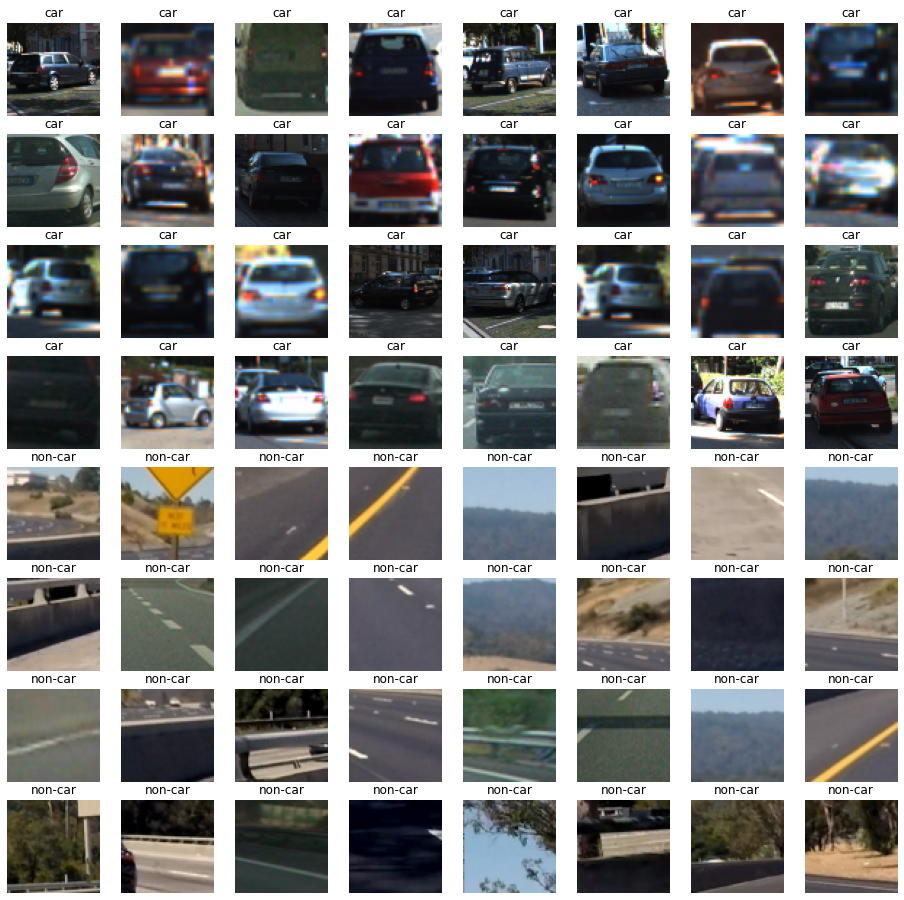

In [8]:
figure, axes = plt.subplots(nrows=8 , ncols=8, figsize=(16, 16))
axes = axes.flatten()

for i in range(32):
    rand_i = np.random.randint(0, len(car_images))
    image = mpimg.imread(car_images[rand_i])
    axes[i].axis('off')
    axes[i].imshow(image)
    axes[i].set_title("car")

for i in range(32, 64):
    rand_i = np.random.randint(0, len(noncar_images))
    image = mpimg.imread(noncar_images[rand_i])
    axes[i].axis('off')
    axes[i].imshow(image)
    axes[i].set_title("non-car")

## Feature Extraction

In [ ]:
# Color and Shape : Raw pixel(resize)
# Color only : Histogram of pixel value
# Shape only : Hisogram of oriened gradients (HOG)

In [15]:
def resized_raw_pixel(img, size=(32, 32)):
    # TODO : resize된 이미지를 flatten 해서 return
    resized_features = cv2.resize(img, size).ravel()
    return resized_features
    
def color_histogram(img, nbins=32, bins_range=(0, 256)):
    # TODO : 각 채널별 히스토그램을 구한 뒤 연결해서 return
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    return hist_features
                                   
def get_hog_feature(img_channel, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2,2),                      
                    visualize=True, feature_vector=True):
    # TODO : 입력된 채널에 대해 HOG Feature vecture return
    hog_features = hog(img_channel, orientations=orientations, 
                                 pixels_per_cell=pixels_per_cell,
                                 cells_per_block=cells_per_block, 
                                 block_norm='L2-Hys', transform_sqrt=False, 
                                 visualize=visualize, feature_vector=feature_vector)
    return hog_features

In [16]:
def extract_features(file_paths, orientations, pixels_per_cell, cells_per_block, 
                     visualize, feature_vector, spatial_size, hist_bins, hist_range):
    features = []
    for file_path in file_paths:
        image = mpimg.imread(file_path)
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        
        # 1. HOG feaure
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_feature = get_hog_feature(feature_image[:, :, channel], orientations,
                             pixels_per_cell, cells_per_block, visualize, feature_vector)
            hog_features.append(hog_feature)
        hog_features = np.ravel(hog_features)
            
        # 2. Resize feature
        resized_features = resized_raw_pixel(feature_image, size=spatial_size)
        # 3. Color histogram
        hist_features = color_histogram(feature_image, hist_bins, hist_range)
        
        # 1+2+3
        feature = np.concatenate((resized_features, hist_features, hog_features))
        features.append(feature)
    
    return features

In [18]:
orientations = 9 # ********
pixels_per_cell = (8, 8) 
cells_per_block = (2,2) # ********
visualize=False
feature_vector=True
spatial_size = (32, 32) # ********
hist_bins = 32 # ********
hist_range = (0, 256)

car_features = extract_features(car_images, orientations, pixels_per_cell, cells_per_block,
                               visualize, feature_vector,
                               spatial_size, hist_bins, hist_range)

noncar_features = extract_features(noncar_images, orientations, pixels_per_cell, cells_per_block,
                               visualize, feature_vector,
                               spatial_size, hist_bins, hist_range)

#### Visualize HOG Feature (for each channels)

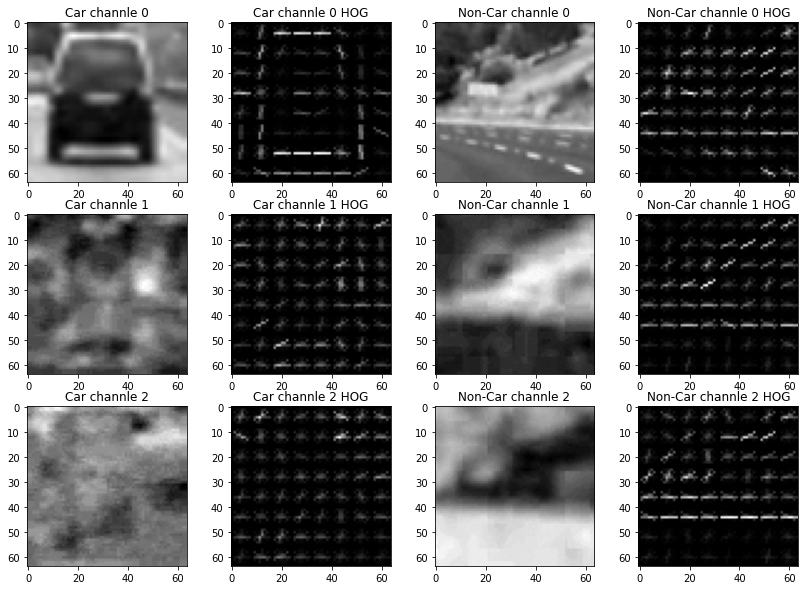

In [39]:
idx = 40
car_sample_image = mpimg.imread(car_images[idx])
noncar_sample_image = mpimg.imread(noncar_images[idx])
car_image_ycrcb = cv2.cvtColor(car_sample_image, cv2.COLOR_RGB2YCrCb)
noncar_image_ycrcb = cv2.cvtColor(noncar_sample_image, cv2.COLOR_RGB2YCrCb)

imgs = []
titles = []
for i in range(3):
    for img_ycrcb, img_type in zip([car_image_ycrcb, noncar_image_ycrcb], ["Car ", "Non-Car "]):
        channel = img_ycrcb[:, :, i]
        imgs.append(channel)
        titles.append(img_type + "channle %d"%i)
        hog_feature, hog_image = get_hog_feature(channel, orientations,
                             pixels_per_cell, cells_per_block, visualize=True, feature_vector=False)
        imgs.append(hog_image)
        titles.append(img_type + "channle %d"%i + " HOG")
        
fig, axes = plt.subplots(3, 4, figsize=(14, 10))
axes = axes.ravel()

for ax, img, title in zip(axes, imgs, titles):
    ax.imshow(img, cmap="gray")
    ax.set_title(title)


## Data Preparation 

In [42]:
print(len(car_features), len(noncar_features))
print(car_features[0].shape, noncar_features[0].shape)

8792 8968
(8460,) (8460,)


In [66]:
X = np.vstack((car_features, noncar_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)) , np.zeros(len(noncar_features))))

In [74]:
# StandardScaler() 
# : sklearn에서 제공하는 변화기의 한종류
# : 평균 0, 표준편차 : 1 로 맞춰줌
# : 변환기 객체에서 제공하는 fit(X) 메소드 - 변환을 위한 평균과 표준편차를 구함
# : 변환기 객체에서 제공하는 transform(X) 메소드 - 실제적인 변환
# : 변환기 객체에서 제공하는 fit_transform() 메소드 - fit과 transform을 이어서 수행
X_scaler = StandardScaler()
X_scaler.fit(X)
scaled_X = X_scaler.transform(X)

print(scaled_X.shape, y.shape)

(17760, 8460) (17760,)


In [73]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape) # 80%의 train용 특성과 정답 데이터
print(X_test.shape, y_test.shape) # 20%의 test용 특성과 정답 데이터 

(14208, 8460) (14208,)
(3552, 8460) (3552,)


## Classifier

In [84]:
# LinearSVC() 
# : sklearn에서 제공하는 모델(학습기/예측기)의 한종류

# : 모델의 객체에서 제공하는 fit(X, y) 메소드 - 학습(훈련)
# : 모델의 객체에서 제공하는 predict(X_new) 메소드 - 예측

tm = cv2.TickMeter()
tm.start()

svc = LinearSVC()
svc.fit(X_train, y_train)

tm.stop()
print("Time to train : ", tm.getTimeMilli())

predict = svc.predict(X_test)
print("Accuracy : ", (predict == y_test).sum() / len(y_test))

Time to train :  28372.7232
Accuracy :  0.9893018018018018


## Saving Model

In [ ]:
orientations = 9 # ********
pixels_per_cell = (8, 8) 
cells_per_block = (2,2) # ********
visualize=False
feature_vector=True
spatial_size = (32, 32) # ********
hist_bins = 32 # ********

In [85]:
# pickle 로 저장

data_pickle = {}
data_pickle["svc"] = svc
data_pickle["X_scaler"] = X_scaler
data_pickle["orientations"] = orientations
data_pickle["cells_per_block"] = cells_per_block
data_pickle["spatial_size"] = spatial_size
data_pickle["hist_bins"] = hist_bins

fd = open("svc_pickle.p", "wb")
pickle.dump(data_pickle, fd)

In [86]:
fd = open("svc_pickle.p", "rb")
data_pickle2 = pickle.load(fd)

In [87]:
svc = data_pickle2["svc"]
X_scaler = data_pickle2["X_scaler"]
orientations = data_pickle2["orientations"]
cells_per_block = data_pickle2["cells_per_block"]
spatial_size = data_pickle2["spatial_size"]
hist_bins = data_pickle2["hist_bins"]

1. 새로운 이미지에 대해

2. Feature Extraction 

3. Feature를 갖고 예측
